In [1]:

import pandas as pd
import pandas as pd
import datetime
from  window_generator  import WindowGenerator
import pandas as pd
import tensorflow as tf
from binance_data import get_binance_data
from data_processing import train_test   , compile_and_fit , normalize , data_parser  , data_for_prediction_parser
import pandas as pd
import models
import pickle
from datetime import timedelta as td


config = tf.compat.v1.ConfigProto(gpu_options = 
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
# device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)


2023-04-22 23:44:46.648845: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-22 23:44:47.224509: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-22 23:44:48.848621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-22 23:44:48.848815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [ ]:
data = loaded_list
### Configuration of the prediction
#variables_used = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume','num_trades','taker_base_vol','taker_quote_vol' ]
#variables_used = df.columns


In [2]:
import config
start_time = "1 Jun 2010"
# Get current date and time
now = datetime.datetime.now()
# Format date and time as a string
end_time = now.strftime("%Y-%m-%d %H:%M:%S")

data = get_binance_data ('BTCUSDT',  start_time, end_time )



In [4]:
start_time = "1 Jun 2010"
# Get current date and time
now = datetime.datetime.now()-td(hours=24)
# Format date and time as a string
end_time = now.strftime("%Y-%m-%d %H:%M:%S")

data = get_binance_data ('BTCUSDT',  start_time, end_time )

# Saving the list to a file
with open('btc_data', 'wb') as f:
    pickle.dump(data, f)

In [2]:
import pickle

# Loading the list from the file
with open('btc_data', 'rb') as f:
    loaded_list = pickle.load(f)

# Printing the loaded list
print(loaded_list)

[[1502942400000, '4261.48000000', '4313.62000000', '4261.32000000', '4308.83000000', '47.18100900', 1502945999999, '202366.13839304', 171, '35.16050300', '150952.47794304', '0'], [1502946000000, '4308.83000000', '4328.69000000', '4291.37000000', '4315.32000000', '23.23491600', 1502949599999, '100304.82356749', 102, '21.44807100', '92608.27972836', '0'], [1502949600000, '4330.29000000', '4345.45000000', '4309.37000000', '4324.35000000', '7.22969100', 1502953199999, '31282.31266989', 36, '4.80286100', '20795.31722405', '0'], [1502953200000, '4316.62000000', '4349.99000000', '4287.41000000', '4349.99000000', '4.44324900', 1502956799999, '19241.05829986', 25, '2.60229200', '11291.34701534', '0'], [1502956800000, '4333.32000000', '4377.85000000', '4333.32000000', '4360.69000000', '0.97280700', 1502960399999, '4239.50358563', 28, '0.81465500', '3552.74681715', '0'], [1502960400000, '4360.00000000', '4445.78000000', '4360.00000000', '4444.00000000', '10.76362300', 1502963999999, '47219.355943

In [172]:
#data = loaded_list
### Configuration of the prediction
#variables_used = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume','num_trades','taker_base_vol','taker_quote_vol' ]
#variables_used = df.columns
#label_width = 12
#input_width=label_width*4
variables_used = ['close']
import numpy as np
from scipy.optimize import minimize , Bounds

# Define the hyperparameters to optimize
hyperparameters = ["label_width" , "input_width"  ]
# Define the objective function to optimize
def objective(hyperparameters , args  ):
    data = args
    label_width = int(hyperparameters[0])
    input_width = int(hyperparameters[1])
    input_shape = (input_width, 1)
    print(f"label_width: {label_width}")
    print(f"input_width: {input_width}")
    print(f"input_shape: {input_shape}")
    model = models.create_Dense(input_shape=input_shape, label_width=label_width)
    training_df = data_parser(data)
    training_df_norm = normalize(training_df, label_width=label_width, window=30)
    train_df, val_df, test_df = train_test(training_df_norm[variables_used])
    wide_window = WindowGenerator(
        input_width=input_width, label_width=label_width, shift=0,
        label_columns=["close"], train_df=train_df, val_df=val_df, test_df=test_df)

    history = compile_and_fit(model, wide_window)

    print(f"Model output shape: {model.output_shape}")

    return model.evaluate(wide_window.test, verbose=0)[0] / label_width


    
# Define the integer bounds for the hyperparameters

# Define the integer bounds for the hyperparameters
lower_bounds = np.array([12, 1])[0:2]
upper_bounds = np.array([48, 12])[0:2]
bounds = Bounds(lower_bounds.astype(int), upper_bounds.astype(int))
extra_args = (data,)
initial_guess = np.array([12, 48]).astype(int)

# Perform the gradient search over the hyperparameters
result = minimize(objective, x0=initial_guess,
  bounds=bounds, method='L-BFGS-B' , args=extra_args)

# Get the optimized hyperparameters
optimized_hyperparameters = result.x


label_width: 12
input_width: 12
input_shape: (12, 1)
Inputs shape: (None, 12, 1)
Labels shape: (None, 12, 1)
Inputs shape: (None, 12, 1)
Labels shape: (None, 12, 1)
Epoch 1/40


2023-04-22 23:39:17.184118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-04-22 23:39:17.184446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


1076/1082 [============================>.] - ETA: 0s - loss: 0.2746 - mean_absolute_error: 0.2073

2023-04-22 23:39:19.695340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-04-22 23:39:19.695708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


1082/1082 [==============================] - 3s 2ms/step - loss: 0.2732 - mean_absolute_error: 0.2064 - val_loss: 0.0035 - val_mean_absolute_error: 0.0324
Epoch 2/40
1082/1082 [==============================] - 2s 2ms/step - loss: 0.0010 - mean_absolute_error: 0.0119 - val_loss: 7.3458e-04 - val_mean_absolute_error: 0.0081
Epoch 3/40
1082/1082 [==============================] - 2s 2ms/step - loss: 0.0019 - mean_absolute_error: 0.0085 - val_loss: 7.1227e-06 - val_mean_absolute_error: 0.0013
Epoch 4/40
1082/1082 [==============================] - 2s 2ms/step - loss: 0.0129 - mean_absolute_error: 0.0312 - val_loss: 4.5683e-05 - val_mean_absolute_error: 0.0042
Epoch 5/40
1082/1082 [==============================] - 2s 2ms/step - loss: 4.9330e-06 - mean_absolute_error: 7.7571e-04 - val_loss: 5.2010e-06 - val_mean_absolute_error: 6.9468e-04
Epoch 6/40
1082/1082 [==============================] - 2s 2ms/step - loss: 0.0100 - mean_absolute_error: 0.0263 - val_loss: 4.8901e-05 - val_mean_absolu

2023-04-22 23:39:52.051977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-04-22 23:39:52.052362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [4946,1]
	 [[{{node Placeholder/_0}}]]


label_width: 12
input_width: 12
input_shape: (12, 1)
Inputs shape: (None, 12, 1)
Labels shape: (None, 12, 1)
Inputs shape: (None, 12, 1)
Labels shape: (None, 12, 1)
Epoch 1/40


2023-04-22 23:39:52.490587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [34619,1]
	 [[{{node Placeholder/_0}}]]
2023-04-22 23:39:52.490952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


1057/1082 [============================>.] - ETA: 0s - loss: 0.3189 - mean_absolute_error: 0.2199

2023-04-22 23:39:55.034298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [9891,1]
	 [[{{node Placeholder/_0}}]]
2023-04-22 23:39:55.034661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


1082/1082 [==============================] - 3s 2ms/step - loss: 0.3119 - mean_absolute_error: 0.2159 - val_loss: 0.0053 - val_mean_absolute_error: 0.0405
Epoch 2/40
1082/1082 [==============================] - 2s 2ms/step - loss: 0.0022 - mean_absolute_error: 0.0181 - val_loss: 2.7008e-05 - val_mean_absolute_error: 0.0021
Epoch 3/40
1082/1082 [==============================] - 2s 2ms/step - loss: 2.7876e-04 - mean_absolute_error: 0.0031 - val_loss: 1.9367e-04 - val_mean_absolute_error: 0.0049
Epoch 4/40
1082/1082 [==============================] - 2s 2ms/step - loss: 0.0057 - mean_absolute_error: 0.0211 - val_loss: 9.9849e-05 - val_mean_absolute_error: 0.0056
Epoch 5/40
1082/1082 [==============================] - 2s 2ms/step - loss: 0.0061 - mean_absolute_error: 0.0182 - val_loss: 4.0692e-04 - val_mean_absolute_error: 0.0067
Epoch 6/40
1082/1082 [==============================] - 2s 2ms/step - loss: 0.0102 - mean_absolute_error: 0.0229 - val_loss: 1.4511e-06 - val_mean_absolute_error

2023-04-22 23:40:41.280319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-04-22 23:40:41.280803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [4946,1]
	 [[{{node Placeholder/_0}}]]


label_width: 12
input_width: 11
input_shape: (11, 1)
Inputs shape: (None, 11, 1)
Labels shape: (None, 12, 1)
Inputs shape: (None, 11, 1)
Labels shape: (None, 12, 1)
Epoch 1/40


2023-04-22 23:40:41.728238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-04-22 23:40:41.728669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [34619,1]
	 [[{{node Placeholder/_0}}]]
2023-04-22 23:40:42.052525: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Incompatible shapes at component 1: expected [?,12,1] but got [32,1,1].
	 [[{{

InvalidArgumentError: Graph execution error:

Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_19178/3144435664.py", line 48, in <module>
      result = minimize(objective, x0=initial_guess,
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/scipy/optimize/_minimize.py", line 696, in minimize
      res = _minimize_lbfgsb(fun, x0, args, jac, bounds,
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/scipy/optimize/_lbfgsb_py.py", line 305, in _minimize_lbfgsb
      sf = _prepare_scalar_function(fun, x0, jac=jac, args=args, epsilon=eps,
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py", line 332, in _prepare_scalar_function
      sf = ScalarFunction(fun, x0, args, grad, hess,
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py", line 177, in __init__
      self._update_grad()
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py", line 256, in _update_grad
      self._update_grad_impl()
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py", line 173, in update_grad
      self.g = approx_derivative(fun_wrapped, self.x, f0=self.f,
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/scipy/optimize/_numdiff.py", line 505, in approx_derivative
      return _dense_difference(fun_wrapped, x0, f0, h,
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/scipy/optimize/_numdiff.py", line 576, in _dense_difference
      df = fun(x) - f0
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/scipy/optimize/_numdiff.py", line 456, in fun_wrapped
      f = np.atleast_1d(fun(x, *args, **kwargs))
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py", line 137, in fun_wrapped
      fx = fun(np.copy(x), *args)
    File "/tmp/ipykernel_19178/3144435664.py", line 30, in objective
      history = compile_and_fit(model, wide_window)
    File "/home/alice/Desktop/btc_forecast/data_processing.py", line 29, in compile_and_fit
      history = model.fit(window.train, epochs=MAX_EPOCHS,
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/keras/engine/training.py", line 1267, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_19178/3144435664.py", line 48, in <module>
      result = minimize(objective, x0=initial_guess,
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/scipy/optimize/_minimize.py", line 696, in minimize
      res = _minimize_lbfgsb(fun, x0, args, jac, bounds,
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/scipy/optimize/_lbfgsb_py.py", line 305, in _minimize_lbfgsb
      sf = _prepare_scalar_function(fun, x0, jac=jac, args=args, epsilon=eps,
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py", line 332, in _prepare_scalar_function
      sf = ScalarFunction(fun, x0, args, grad, hess,
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py", line 177, in __init__
      self._update_grad()
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py", line 256, in _update_grad
      self._update_grad_impl()
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py", line 173, in update_grad
      self.g = approx_derivative(fun_wrapped, self.x, f0=self.f,
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/scipy/optimize/_numdiff.py", line 505, in approx_derivative
      return _dense_difference(fun_wrapped, x0, f0, h,
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/scipy/optimize/_numdiff.py", line 576, in _dense_difference
      df = fun(x) - f0
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/scipy/optimize/_numdiff.py", line 456, in fun_wrapped
      f = np.atleast_1d(fun(x, *args, **kwargs))
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py", line 137, in fun_wrapped
      fx = fun(np.copy(x), *args)
    File "/tmp/ipykernel_19178/3144435664.py", line 30, in objective
      history = compile_and_fit(model, wide_window)
    File "/home/alice/Desktop/btc_forecast/data_processing.py", line 29, in compile_and_fit
      history = model.fit(window.train, epochs=MAX_EPOCHS,
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/alice/Desktop/btc_forecast/.venv/lib/python3.10/site-packages/keras/engine/training.py", line 1267, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Incompatible shapes at component 1: expected [?,12,1] but got [32,1,1].
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
  (1) INVALID_ARGUMENT:  Incompatible shapes at component 1: expected [?,12,1] but got [32,1,1].
	 [[{{node IteratorGetNext}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_1241347]

In [15]:
from config import config
import numpy as np
from scipy.optimize import minimize , Bounds
import inspect
import models
# Get a list of all the functions in my_module
models = [obj for name, obj in inspect.getmembers(models, inspect.isfunction)]
# Call each function in turn
for Model in models:
        model = Model(input_shape=config.input_shape, label_width=config.label_width)
        training_df = data_parser(data)
        training_df_norm = normalize(training_df, label_width=config.label_width, window=30)
        train_df, val_df, test_df = train_test(training_df_norm[config.variables_used])
        wide_window = WindowGenerator(
                input_width=config.input_width, label_width=config.label_width, shift=0,
                label_columns=config.variables_used, train_df=train_df, val_df=val_df, test_df=test_df)
        history = compile_and_fit(model, wide_window)

        metadata = { "model_name" : model.name , "model" : model , "history" : history , "config" : config }
        with open(f"models/{model.name}", 'wb') as f:
                pickle.dump(metadata, f)
        #save models
        model.save(f"models/{model.name}.h5" ,overwrite=True)


Conv1D
Inputs shape: (None, 200, 1)
Labels shape: (None, 12, 1)
Inputs shape: (None, 200, 1)
Labels shape: (None, 12, 1)
Epoch 1/40


2023-04-22 23:59:56.065036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [34738,1]
	 [[{{node Placeholder/_0}}]]
2023-04-22 23:59:56.065439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


1075/1080 [============================>.] - ETA: 0s - loss: 1.8443 - mean_absolute_error: 0.8644

2023-04-23 00:00:03.606131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [9727]
	 [[{{node Placeholder/_8}}]]
2023-04-23 00:00:03.606469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


1080/1080 [==============================] - 8s 5ms/step - loss: 1.8424 - mean_absolute_error: 0.8636 - val_loss: 1.0266 - val_mean_absolute_error: 0.6815
Epoch 2/40
1080/1080 [==============================] - 5s 5ms/step - loss: 1.1320 - mean_absolute_error: 0.6672 - val_loss: 0.7806 - val_mean_absolute_error: 0.5909
Epoch 3/40
1080/1080 [==============================] - 5s 5ms/step - loss: 1.0193 - mean_absolute_error: 0.6259 - val_loss: 0.7432 - val_mean_absolute_error: 0.5775
Epoch 4/40
1080/1080 [==============================] - 5s 5ms/step - loss: 0.8806 - mean_absolute_error: 0.5800 - val_loss: 0.8389 - val_mean_absolute_error: 0.6087
Epoch 5/40
1080/1080 [==============================] - 5s 5ms/step - loss: 0.8855 - mean_absolute_error: 0.5780 - val_loss: 0.6026 - val_mean_absolute_error: 0.5073
Epoch 6/40
1080/1080 [==============================] - 5s 5ms/step - loss: 0.7869 - mean_absolute_error: 0.5482 - val_loss: 0.5653 - val_mean_absolute_error: 0.4885
Epoch 7/40
1080

TypeError: cannot pickle 'module' object

In [141]:
import numpy as np
import matplotlib.pyplot as plt

end_time = datetime.datetime.now()
start_time = end_time - datetime.timedelta(hours=1000)
# Convert the start and end time to milliseconds
start_timestamp = int(start_time.timestamp() * 1000)
end_timestamp = int(end_time.timestamp() * 1000)
data_pred = get_binance_data('BTCUSDT',start_timestamp, end_timestamp)
df_pred = data_parser(data_pred)
df_pred_norm = normalize(df_pred,label_width=label_width,window=30)
prediction_data = df_pred_norm.tail(input_width)
data_for_prediction = data_for_prediction_parser(prediction_data , input_shape=input_shape)

df_pred.index.max() , df_pred_norm.index.max() 


(Timestamp('2023-04-22 21:00:00'), Timestamp('2023-04-22 21:00:00'))

In [142]:

td = pd.Timedelta(hours=label_width)
prediction = model.predict(data_for_prediction)[0]

# create a new DatetimeIndex for the next 24 hours
dti_new = df_pred["close"].tail(label_width).index + td
normalized_prediction = pd.DataFrame(prediction, columns=["close"] , index=dti_new ) 
normalized_prediction.index.min() , normalized_prediction.index.max()

1/1 [==============================] - 0s 15ms/step


(Timestamp('2023-04-22 22:00:00'), Timestamp('2023-04-23 09:00:00'))

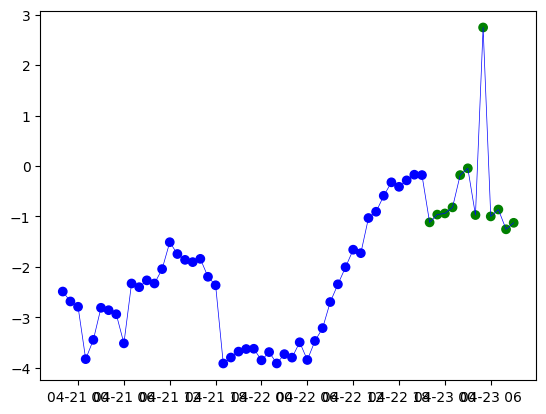

(None,
 DatetimeIndex(['2023-04-22 22:00:00', '2023-04-22 23:00:00',
                '2023-04-23 00:00:00', '2023-04-23 01:00:00',
                '2023-04-23 02:00:00', '2023-04-23 03:00:00',
                '2023-04-23 04:00:00', '2023-04-23 05:00:00',
                '2023-04-23 06:00:00', '2023-04-23 07:00:00',
                '2023-04-23 08:00:00', '2023-04-23 09:00:00'],
               dtype='datetime64[ns]', name='open_time', freq=None))

In [143]:
import pandas as pd
import matplotlib.pyplot as plt

# Concatenate the two DataFrames
combined_df = pd.concat([df_pred_norm[variables_used].tail(48), normalized_prediction])

# Create a color map with blue for the first part and green for the second part
colors = ['blue'] * 48 + ['green'] * len(normalized_prediction)

# Plot the data using the color map and soft lines
plt.plot(combined_df, color='blue', linestyle='-', linewidth=0.5)
plt.scatter(combined_df.index, combined_df, c=colors)

# Show the plot
plt.show() , dti_new

In [157]:

mean = df_pred["close"].shift( label_width).rolling(30).mean().tail(label_width )
mean.index = dti_new
std = df_pred["close"].shift(label_width).rolling(30).std().tail(label_width )
std.index =dti_new
predictions_no_ma  = normalized_prediction["close"]  *std + mean
predictions_no_ma


open_time
2023-04-22 22:00:00    27657.037255
2023-04-22 23:00:00    27651.035350
2023-04-23 00:00:00    27603.127994
2023-04-23 01:00:00    27605.785149
2023-04-23 02:00:00    27818.344381
2023-04-23 03:00:00    27841.760184
2023-04-23 04:00:00    27428.653934
2023-04-23 05:00:00    28936.360673
2023-04-23 06:00:00    27360.539593
2023-04-23 07:00:00    27384.866684
2023-04-23 08:00:00    27189.524629
2023-04-23 09:00:00    27215.861788
Name: close, dtype: float64

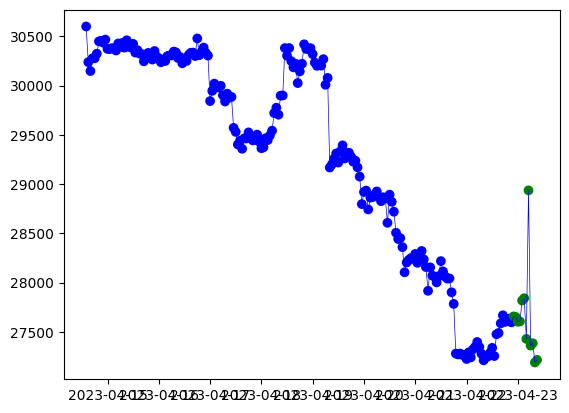

In [158]:
import pandas as pd
import matplotlib.pyplot as plt

# Concatenate the two DataFrames
df1 = df_pred["close"].tail(input_width)
df2 = predictions_no_ma.squeeze()  # Convert the DataFrame into a pandas Series
combined_df = pd.concat([df1, df2])

# Calculate the length of the second part
second_part_length = len(combined_df) - input_width

# Create a color map with blue for the first part and green for the second part
colors = ['blue'] * input_width + ['green'] * second_part_length

# Plot the data using the color map and soft lines
plt.plot(combined_df.index, combined_df, color='blue', linestyle='-', linewidth=0.5)
plt.scatter(combined_df.index, combined_df, c=colors)

# Show the plot
plt.show()

212 212


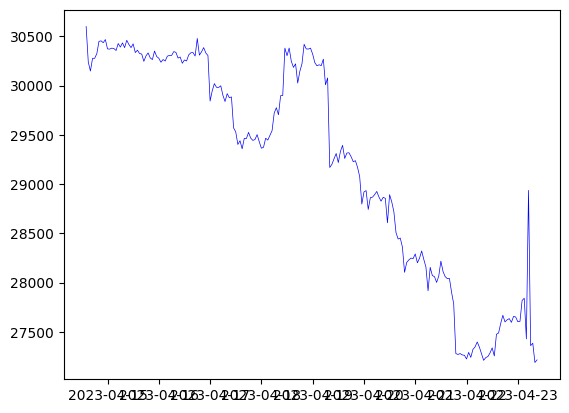

In [159]:

# Create a color map with blue for the first part and green for the second part
colors = ['blue'] * input_width + ['green'] * len(prediction__)
print( len(colors ) , len(combined_df))
# Plot the data using the color map and soft lines
plt.plot(combined_df, color='blue', linestyle='-', linewidth=0.5)
#plt.scatter(combined_df.index, combined_df,c=colors)

# Show the plot
plt.show()

In [150]:
# performance and validated performance
pd.DataFrame(performance, index=["MSE" , "MAE "]) 
pd.DataFrame(val_performance, index=["MSE" , "MAE "]) 

NameError: name 'performance' is not defined

In [161]:
#save models
#for model in models:
model.save(f"{model.name}.h5" ,overwrite=True)

In [45]:
import glob
import tensorflow as tf
model_files = glob.glob("*.h5")
loaded_models={}
for model_file in model_files:
    loaded_models[model_file.split(".h5")[0]] = tf.keras.models.load_model(model_file) 

['Dense.h5', 'LSTM2.h5', 'LSTM.h5', 'Conv1D.h5']


2023-04-09 00:42:36.321298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-09 00:42:36.322417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-09 00:42:36.323167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [55]:
def predict(model , data_for_prediction , df_pred , label_width , imput_width , input_shape):
    td = pd.Timedelta(hours=label_width)
    prediction = loaded_models[model].predict(data_for_prediction)[0]

    # create a new DatetimeIndex for the next 24 hours
    dti_new = df_pred["close"].tail(label_width).index + td
    normalized_prediction = pd.DataFrame(prediction, columns=["close"] , index=dti_new ) 

    mean = df_pred["close"].shift(imput_width -label_width).rolling(30).mean().tail(label_width )
    mean.index = dti_new
    std = df_pred["close"].shift(imput_width -label_width).rolling(30).std().tail(label_width )
    std.index =dti_new
    predictions_no_ma  = normalized_prediction["close"]  *std + mean
    #print( predictions_no_ma)

    # create a new DataFrame with the same columns as 'df' but with NaN values for the 'open_time' column and the new DatetimeIndex
    prediction__ = pd.DataFrame({'close': predictions_no_ma.values }, index=dti_new, columns=df_pred.columns)

    data_pred = get_binance_data('BTCUSDT','1 feb 2023', '7 Apr 2023')
    df_pred = data_parser(data_pred)
    df_pred_norm = normalize(df_pred,imput_width=imput_width)
    prediction_data = df_pred_norm.tail(imput_width)
    data_for_prediction = data_for_prediction_parser(prediction_data , input_shape=input_shape)




In [54]:
from controllers import predict

predict(loaded_models["Dense"] , data_for_prediction , df_pred , label_width , imput_width , input_shape)

1/1 [==============================] - 0s 14ms/step


TypeError: normalize() got an unexpected keyword argument 'imput_width'

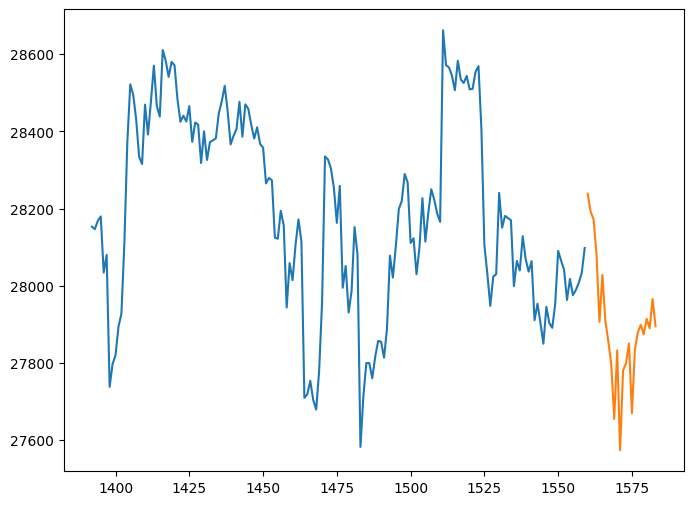

In [102]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


ModuleNotFoundError: No module named 'sklearn'

In [6]:
bitcoin_data = data
df = pd.DataFrame(data , columns = ['open_time','open', 'high', 'low', 'close', 'volume','close_time', 'quote_asset_volume','num_trades','taker_base_vol','taker_quote_vol', 'ignore'] )
df['open_time'] = pd.to_datetime(df['open_time'])
df.set_index('open_time', inplace=True)
df = df.astype(float)
df.drop( ["ignore"] , axis=1  , inplace=True)
df.head()

open     high      low    close       volume  \
open_time                                                                     
1970-01-01 00:25:27.811200  7485.01  7538.00  7477.50  7517.84  1381.859204   
1970-01-01 00:25:27.814800  7515.03  7515.04  7478.43  7483.99   845.777769   
1970-01-01 00:25:27.818400  7483.99  7522.54  7480.00  7487.82   954.614574   
1970-01-01 00:25:27.822000  7487.82  7509.99  7454.35  7495.13   978.126602   
1970-01-01 00:25:27.825600  7495.13  7497.07  7455.48  7491.22   962.828704   

                              close_time  quote_asset_volume  num_trades  \
open_time                                                                  
1970-01-01 00:25:27.811200  1.527815e+12        1.037592e+07      8465.0   
1970-01-01 00:25:27.814800  1.527818e+12        6.341206e+06     14282.0   
1970-01-01 00:25:27.818400  1.527822e+12        7.162305e+06     12365.0   
1970-01-01 00:25:27.822000  1.527826e+12        7.322881e+06     11082.0   
1970-01-01 00:25:27.825600  1.527829e+12        7.202737e+06     14969.0   

                            taker_base_vol  taker_quote_vol  
open_time                                                    
1970-01-01 00:25:27.811200      859.825064     6.456825e+06  
1970-01-01 00:25:27.814800      492.022255     3.688720e+06  
1970-01-01 00:25:27.818400      587.432232     4.407405e+06  
1970-01-01 00:25:27.822000      537.670795     4.025818e+06  
1970-01-01 00:25:27.825600      538.148326     4.026065e+06

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

window_size = 24*7
predicionlenght = 24
rmse_list = []
arima_model = SARIMAX(df["close"].diff(), order=(2,1,10))
arima_fit = arima_model.fit()
predictions = arima_fit.forecast(steps=predicionlenght)
print(predictions)
# Iterate through windows of test data
""" for i in range(len(df) - window_size):
    # Split data into training and testing sets
    train_data = df["close"].iloc[i:i+window_size]
    test_data = df["close"].iloc[i+window_size:i+window_size+predicionlenght]
    print(train_data , test_data )
    # Fit ARIMA model to training data
    arima_model = ARIMA(train_data, order=(1,1,1))
    arima_fit = arima_model.fit()

    # Predict Bitcoin prices for test data
    predictions = arima_fit.forecast(steps=predicionlenght)
    print(predictions)

    # Calculate root mean squared error (RMSE)
    rmse = np.sqrt(mean_squared_error(test_data, predictions))

    # Add RMSE value to list
    rmse_list.append(rmse)

# Calculate average RMSE over all windows
avg_rmse = np.mean(rmse_list)

print("Average RMSE:", avg_rmse) """


/home/alice/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alice/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alice/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alice/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


42101     4.833385
42102     2.683808
42103   -10.799863
42104    14.325154
42105    -2.154795
42106    -2.599024
42107     4.118660
42108    -4.950964
42109     6.081731
42110    -3.675887
42111     1.967215
42112     2.023430
42113    -3.618877
42114     5.860290
42115    -4.611171
42116     3.765349
42117    -0.095667
42118    -1.805616
42119     4.879351
42120    -4.736051
42121     4.940660
42122    -1.958960
42123     0.187635
42124     3.342799
Name: predicted_mean, dtype: float64


/home/alice/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


' for i in range(len(df) - window_size):\n    # Split data into training and testing sets\n    train_data = df["close"].iloc[i:i+window_size]\n    test_data = df["close"].iloc[i+window_size:i+window_size+predicionlenght]\n    print(train_data , test_data )\n    # Fit ARIMA model to training data\n    arima_model = ARIMA(train_data, order=(1,1,1))\n    arima_fit = arima_model.fit()\n\n    # Predict Bitcoin prices for test data\n    predictions = arima_fit.forecast(steps=predicionlenght)\n    print(predictions)\n\n    # Calculate root mean squared error (RMSE)\n    rmse = np.sqrt(mean_squared_error(test_data, predictions))\n\n    # Add RMSE value to list\n    rmse_list.append(rmse)\n\n# Calculate average RMSE over all windows\navg_rmse = np.mean(rmse_list)\n\nprint("Average RMSE:", avg_rmse) '

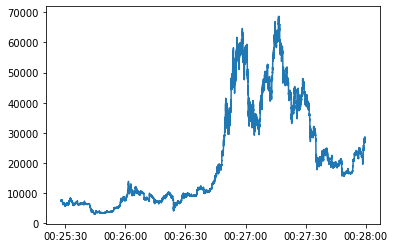

In [129]:
import matplotlib.pyplot as plt

# Plot the original time series
plt.plot(df.index, df['close'], label='Original')

# Plot the predicted values
plt.plot(predictions.index, predictions.values, label='Predicted')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ARIMA Predictions')

# Show the legend and plot
plt.legend()
plt.show()

In [23]:
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                42101
Model:                ARIMA(2, 1, 10)   Log Likelihood             -285929.669
Date:                Fri, 24 Mar 2023   AIC                         571885.338
Time:                        21:34:44   BIC                         571997.759
Sample:                             0   HQIC                        571920.837
                              - 42101                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6898      0.003   -600.142      0.000      -1.695      -1.684
ar.L2         -0.9830      0.003   -347.409      0.000      -0.989      -0.977
ma.L1          0.6902      0.003    199.799      0.000       0.683       0.697
ma.L2         -0.7236      0.003   -223.210      0.000      -0.730      -0.717
ma.L3         -0.9890      0.004   -232.201      0.000      -0.997      -0.981
ma.L4         -0.0131      0.004     -3.351      0.001      -0.021      -0.005
ma.L5         -0.0078      0.004     -2.044      0.041      -0.015      -0.000
ma.L6          0.0294      0.004      7.017      0.000       0.021       0.038
ma.L7          0.0343      0.004      8.751      0.000       0.027       0.042
ma.L8         -0.0108      0.003     -3.373      0.001      -0.017      -0.005
ma.L9         -0.0097      0.003     -3.510      0.000      -0.015      -0.004
ma.L10         0.0001      0.002      0.055      0.956      -0.004       0.005
sigma2      4.689e+04     90.050    520.686      0.000    4.67e+04    4.71e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1448936.36
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              17.72   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
non_stationary_data = df[["close"] ]

In [19]:
from scipy.stats import boxcox

non_stationary_data['value_diff'] = non_stationary_data["close"].diff()
non_stationary_data['value_seasonal_diff'] = non_stationary_data['close'].diff(12)
non_stationary_data['value_log'] = np.log(non_stationary_data['close'])
non_stationary_data['value_boxcox'], fitted_lambda = boxcox(non_stationary_data['close'])



/tmp/ipykernel_8114/991760935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_stationary_data['value_diff'] = non_stationary_data["close"].diff()
/tmp/ipykernel_8114/991760935.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_stationary_data['value_seasonal_diff'] = non_stationary_data['close'].diff(12)
/tmp/ipykernel_8114/991760935.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [20]:
from statsmodels.tsa.stattools import adfuller
for column in non_stationary_data.columns:
    adf_result = adfuller(non_stationary_data[column].dropna())
    print(f'ADF Statistic: {adf_result[0]} for {column}')
    print(f'p-value: {adf_result[1]}')



ADF Statistic: -1.3092747294283693 for close
p-value: 0.6249185036138085
ADF Statistic: -29.42270581200733 for value_diff
p-value: 0.0
ADF Statistic: -24.9581636610649 for value_seasonal_diff
p-value: 0.0
ADF Statistic: -0.9720612724743178 for value_log
p-value: 0.7633174550940749
ADF Statistic: -0.9668790211131959 for value_boxcox
p-value: 0.765151975502466


<Figure size 864x432 with 0 Axes>

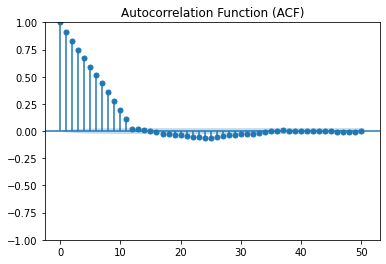

/home/alice/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 864x432 with 0 Axes>

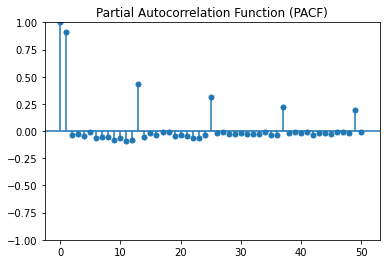

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

stationary_series = non_stationary_data['value_seasonal_diff'].dropna()
# ACF plot
plt.figure(figsize=(12, 6))
plot_acf(stationary_series, lags=50, alpha=0.05)
plt.title("Autocorrelation Function (ACF)")
plt.show()

# PACF plot
plt.figure(figsize=(12, 6))
plot_pacf(stationary_series, lags=50, alpha=0.05)
plt.title("Partial Autocorrelation Function (PACF)")
plt.show() 
